In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
cwd = os.getcwd()

def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MAE: {:.2f}'.format(mae))
    print('RMSE: {:.2f}'.format(rmse))
    print('')
    print('')
    return mae, rmse

In [3]:
sl = pd.read_csv('dataset/SCED (5m).csv')
sl['sced_time_stamp_local'] = pd.to_datetime(sl['sced_time_stamp_local'])
sl.set_index('sced_time_stamp_local', inplace=True)
sl = sl.resample('h').mean()
date_range = pd.date_range(start=sl.index.min(), end=sl.index.max(), freq='h')
sl = sl[~sl.index.duplicated(keep='first')]
sl = sl.reindex(date_range, fill_value=np.nan)
sl.interpolate(method='time', inplace=True)


In [4]:
dap = pd.read_csv('dataset/DAP (1hr).csv')
dap['timestamp'] = pd.to_datetime(dap['timestamp'])
dap.set_index('timestamp', inplace=True)
date_range = pd.date_range(start=dap.index.min(), end='2024-01-01 23:55:00', freq='h')
dap = dap[~dap.index.duplicated(keep='first')]
dap = dap.reindex(date_range, fill_value=np.nan)
dap.interpolate(method='time', inplace=True)
# 24-hour average (24 hours * 1 reading per hour = 24 samples)
dap['avg_24h'] = dap['SystemLambda'].rolling(window=24, min_periods=1).mean()

# 7-day average (7 days * 24 hours = 168 samples)
dap['avg_7d'] = dap['SystemLambda'].rolling(window=168, min_periods=1).mean()

dap

/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_3606/2614341532.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dap['timestamp'] = pd.to_datetime(dap['timestamp'])


,SystemLambda,avg_24h,avg_7d
2019-01-02 00:00:00,23.9250,23.925000,23.925000
2019-01-02 01:00:00,23.3140,23.619500,23.619500
2019-01-02 02:00:00,23.3475,23.528833,23.528833
2019-01-02 03:00:00,23.0595,23.411500,23.411500
2019-01-02 04:00:00,25.2672,23.782640,23.782640
...,...,...,...
2024-01-01 19:00:00,23.1651,19.456800,20.673207
2024-01-01 20:00:00,23.2113,19.725025,20.631249
2024-01-01 21:00:00,21.3244,19.988396,20.604641
2024-01-01 22:00:00,20.3351,20.178613,20.545795


In [5]:
current_fuel = pd.read_csv('dataset/Fuel (5m).csv')
current_fuel['interval_start_local'] = pd.to_datetime(current_fuel['interval_start_local'])
current_fuel.set_index('interval_start_local', inplace=True)
date_range = pd.date_range(start=current_fuel.index.min(), end='2024-01-01 23:55:00', freq='h')
current_fuel = current_fuel[~current_fuel.index.duplicated(keep='first')]
current_fuel = current_fuel.reindex(date_range, fill_value=np.nan)
current_fuel.interpolate(method='time', inplace=True)

In [6]:
current_fuel

,coal_and_lignite,hydro,nuclear,power_storage,solar,wind,natural_gas,other
2019-01-01 00:00:00,6116.419040,185.465296,3895.951940,0.0,0.0,14311.36445,12512.80815,2.534772
2019-01-01 01:00:00,6423.242360,186.667008,3894.973176,0.0,0.0,14298.52586,12434.13638,2.947464
2019-01-01 02:00:00,6309.280752,187.408832,3894.733152,0.0,0.0,14030.82875,12797.25831,-1.954544
2019-01-01 03:00:00,6416.671292,187.817564,3894.714576,0.0,0.0,13610.13937,13279.01803,1.887324
2019-01-01 04:00:00,6569.580884,186.990116,3892.748912,0.0,0.0,13414.14969,13585.26799,-0.201100
...,...,...,...,...,...,...,...,...
2024-01-01 19:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000
2024-01-01 20:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000
2024-01-01 21:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000
2024-01-01 22:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000


In [7]:
current_renewables = current_fuel.copy()
current_renewables["renewable"] = (
    current_renewables["solar"] +
    current_renewables["hydro"] +
    current_renewables["wind"]
)
current_renewables = current_renewables[["renewable"]]


In [8]:
current_load = pd.read_csv('dataset/Load (5m).csv')
current_load['interval_start_local'] = pd.to_datetime(current_load['interval_start_local'])
current_load.set_index('interval_start_local', inplace=True)
date_range = pd.date_range(start=current_load.index.min(), end='2024-01-01 23:55:00', freq='h')
current_load = current_load[~current_load.index.duplicated(keep='first')]
current_load = current_load.reindex(date_range, fill_value=np.nan)
current_load.interpolate(method='time', inplace=True)


In [9]:
current_nonrenew = pd.DataFrame()
current_nonrenew["non-renew"] = current_load["load"] - current_renewables["renewable"]

In [10]:
forecasted_tlf = pd.read_csv('dataset/FORECASTED_TLF (15m).csv')
forecasted_tlf['datetime'] = pd.to_datetime(forecasted_tlf['datetime'])
forecasted_tlf.set_index('datetime', inplace=True)
date_range = pd.date_range(start=forecasted_tlf.index.min(), end='2024-01-01 23:55:00', freq='h')
forecasted_tlf = forecasted_tlf[~forecasted_tlf.index.duplicated(keep='first')]
forecasted_tlf = forecasted_tlf.reindex(date_range, fill_value=np.nan)
forecasted_tlf.interpolate(method='time', inplace=True)


In [11]:
# Read the CSV file for natural gas prices
ng_price = pd.read_csv('dataset/NaturalGasPrice (1D).csv')

# Convert the 'datetime' column to datetime objects
ng_price['datetime'] = pd.to_datetime(ng_price['Date'])

# Set the 'datetime' column as the index
ng_price.set_index('datetime', inplace=True)

# Create an hourly date range from the minimum datetime up to '2024-01-01 23:55:00'
date_range = pd.date_range(start=ng_price.index.min(), end='2024-01-01 23:55:00', freq='h')

# Remove duplicated datetime entries, keeping the first occurrence
ng_price = ng_price[~ng_price.index.duplicated(keep='first')]

# Reindex the DataFrame to the hourly date range, filling missing entries with NaN
ng_price = ng_price.reindex(date_range, fill_value=np.nan)

# Interpolate missing values using time-based interpolation
ng_price.interpolate(method='time', inplace=True)
ng_price.drop(columns=['Date'], inplace=True)
ng_price

/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_3606/2646805775.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ng_price.interpolate(method='time', inplace=True)


,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
1997-01-07 00:00:00,3.820000
1997-01-07 01:00:00,3.819167
1997-01-07 02:00:00,3.818333
1997-01-07 03:00:00,3.817500
1997-01-07 04:00:00,3.816667
...,...
2024-01-01 19:00:00,2.580000
2024-01-01 20:00:00,2.580000
2024-01-01 21:00:00,2.580000
2024-01-01 22:00:00,2.580000


In [12]:
# Prepare final dataframe
df = pd.concat([dap, sl, forecasted_tlf, ng_price, current_nonrenew], axis=1)

# Rename columns (adding Natural Gas at the end)
df.columns = ['DAP', 'DAP 24H', 'DAP 7D', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew']

df.dropna(inplace=True)

df

,DAP,DAP 24H,DAP 7D,SCED,F_TLF,NG Price,Non-Renew
2019-01-02 00:00:00,23.9250,23.925000,23.925000,26.216109,0.016499,3.250000,36508.703164
2019-01-02 01:00:00,23.3140,23.619500,23.619500,25.671136,0.016441,3.227917,35983.092128
2019-01-02 02:00:00,23.3475,23.528833,23.528833,24.970952,0.016411,3.205833,35550.176684
2019-01-02 03:00:00,23.0595,23.411500,23.411500,24.787712,0.016441,3.183750,35511.693684
2019-01-02 04:00:00,25.2672,23.782640,23.782640,24.887786,0.016534,3.161667,36565.635248
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,17.351446,20.111057,14.422107,0.021356,2.580000,29417.400000
2023-12-31 20:00:00,16.7739,17.394163,20.122605,12.597410,0.021367,2.580000,26543.200000
2023-12-31 21:00:00,15.0035,17.432750,20.133511,10.170172,0.021383,2.580000,24706.800000
2023-12-31 22:00:00,15.7699,17.498283,20.154248,9.872549,0.021408,2.580000,23992.100000


In [13]:

import holidays

# Get official Texas holidays
tx_holidays = holidays.US(state='TX')  # includes state + federal holidays observed in Texas

# Add holiday indicator to your DataFrame (assumes datetime index)
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x.date() in tx_holidays else 0)

df

,DAP,DAP 24H,DAP 7D,SCED,F_TLF,NG Price,Non-Renew,is_holiday
2019-01-02 00:00:00,23.9250,23.925000,23.925000,26.216109,0.016499,3.250000,36508.703164,0
2019-01-02 01:00:00,23.3140,23.619500,23.619500,25.671136,0.016441,3.227917,35983.092128,0
2019-01-02 02:00:00,23.3475,23.528833,23.528833,24.970952,0.016411,3.205833,35550.176684,0
2019-01-02 03:00:00,23.0595,23.411500,23.411500,24.787712,0.016441,3.183750,35511.693684,0
2019-01-02 04:00:00,25.2672,23.782640,23.782640,24.887786,0.016534,3.161667,36565.635248,0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,17.351446,20.111057,14.422107,0.021356,2.580000,29417.400000,0
2023-12-31 20:00:00,16.7739,17.394163,20.122605,12.597410,0.021367,2.580000,26543.200000,0
2023-12-31 21:00:00,15.0035,17.432750,20.133511,10.170172,0.021383,2.580000,24706.800000,0
2023-12-31 22:00:00,15.7699,17.498283,20.154248,9.872549,0.021408,2.580000,23992.100000,0


In [14]:
## log transform
log_data = df.copy(deep=True)

columns_to_log = ['DAP', 'DAP 24H', 'DAP 7D', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew']

offsets = {}           # column → min value
for col in columns_to_log:
    offsets[col] = df[col].min()
    log_data[col] = np.log(df[col] - offsets[col] + 1)

# 3 years training, 1 year validation, 1 year testing
x_train_df_reg = log_data.loc[:'2021-12-31 23:55:00'].iloc[:, :]
x_val_df_reg = log_data.loc['2022-01-01 00:00:00':'2022-12-31 23:55:00'].iloc[:, :]
x_test_df_reg = log_data.loc['2023-01-01 00:00:00':].iloc[:, :]

# Change target variable to DAP
y_train_df_reg = log_data.loc[:'2021-12-31 23:55:00'].iloc[:, :1]
y_val_df_reg = log_data.loc['2022-01-01 00:00:00':'2022-12-31 23:55:00'].iloc[:, :1]
y_test_df_reg = log_data.loc['2023-01-01 00:00:00':].iloc[:, :1]

x_train_df_reg.reset_index(drop=True, inplace=True)
x_val_df_reg.reset_index(drop=True, inplace=True)
x_test_df_reg.reset_index(drop=True, inplace=True)

# Standardization
x_mean_reg, x_std_reg = x_train_df_reg.mean(), x_train_df_reg.std()
y_mean_reg, y_std_reg = y_train_df_reg.mean(), y_train_df_reg.std()

x_std_reg = x_std_reg + 0.00001

x_train_reg = (x_train_df_reg - x_mean_reg) / x_std_reg
x_val_reg = (x_val_df_reg - x_mean_reg) / x_std_reg
x_test_reg = (x_test_df_reg - x_mean_reg) / x_std_reg

y_train_reg = (y_train_df_reg - y_mean_reg) / y_std_reg
y_val_reg = (y_val_df_reg - y_mean_reg) / y_std_reg
y_test_reg = (y_test_df_reg - y_mean_reg) / y_std_reg

# Shift the data for the lags
n_steps_in = 24
n_steps_out = 24

x_train_lstm = np.array([x_train_reg[i:i+n_steps_in] for i in range(0, x_train_reg.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train_reg[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train_reg.shape[0]-n_steps_in-n_steps_out+1)])

x_val_lstm = np.array([x_val_reg[i:i+n_steps_in] for i in range(0, x_val_reg.shape[0]-n_steps_in-n_steps_out+1)])
y_val_lstm = np.array([y_val_reg[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_val_reg.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test_reg[i:i+n_steps_in] for i in range(0, x_test_reg.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test_reg[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test_reg.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape, y_train_lstm.shape, x_val_lstm.shape, y_val_lstm.shape, x_test_lstm.shape, y_test_lstm.shape)


(26233, 24, 8) (26233, 24, 1) (8713, 24, 8) (8713, 24, 1) (8713, 24, 8) (8713, 24, 1)


In [15]:
y_train_lstm = y_train_lstm.squeeze(-1)
y_val_lstm = y_val_lstm.squeeze(-1)
y_test_lstm = y_test_lstm.squeeze(-1)

In [16]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a directory for saving the model if it doesn't exist
model_dir = os.path.join(os.getcwd(), 'saved_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]        # take output from last time step
        out = self.dropout(out)    # apply dropout before dense layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [18]:
# Set hyperparameters (same as before)
n_neurons = 64
learning_rate = 0.0005
batch_size = 64
num_epochs = 50
patience = 50  # for early stopping

input_size = x_train_lstm.shape[2]  # number of features
output_size = y_train_lstm.shape[1]  # number of time steps out (24)

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, n_neurons, output_size, dropout_rate=0.3).to(device)
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoaders
train_dataset = TensorDataset(torch.tensor(x_train_lstm, dtype=torch.float32),
                              torch.tensor(y_train_lstm, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(x_val_lstm, dtype=torch.float32),
                            torch.tensor(y_val_lstm, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop with early stopping
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Check early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'DAP_Model_Huber.pt'))
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

/Users/natowei/ConcordNewEnergy/myenv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/50, Train Loss: 0.1366, Val Loss: 0.2567
Epoch 2/50, Train Loss: 0.1195, Val Loss: 0.1995
Epoch 3/50, Train Loss: 0.1114, Val Loss: 0.1425
Epoch 4/50, Train Loss: 0.1070, Val Loss: 0.1553
Epoch 5/50, Train Loss: 0.0917, Val Loss: 0.1897
Epoch 6/50, Train Loss: 0.0722, Val Loss: 0.1842
Epoch 7/50, Train Loss: 0.0630, Val Loss: 0.1289
Epoch 8/50, Train Loss: 0.0647, Val Loss: 0.1624
Epoch 9/50, Train Loss: 0.0599, Val Loss: 0.1469
Epoch 10/50, Train Loss: 0.0618, Val Loss: 0.2150
Epoch 11/50, Train Loss: 0.0773, Val Loss: 0.1435
Epoch 12/50, Train Loss: 0.0683, Val Loss: 0.1467
Epoch 13/50, Train Loss: 0.0592, Val Loss: 0.1321
Epoch 14/50, Train Loss: 0.0678, Val Loss: 0.1817
Epoch 15/50, Train Loss: 0.0681, Val Loss: 0.1605
Epoch 16/50, Train Loss: 0.0780, Val Loss: 0.1420
Epoch 17/50, Train Loss: 0.0611, Val Loss: 0.1408
Epoch 18/50, Train Loss: 0.0574, Val Loss: 0.1541
Epoch 19/50, Train Loss: 0.0549, Val Loss: 0.1537
Epoch 20/50, Train Loss: 0.0535, Val Loss: 0.1759
Epoch 21/

In [19]:
# Reload the best model
model.load_state_dict(torch.load(os.path.join(model_dir, 'DAP_Model_Huber.pt')))

# Make predictions on the test set
model.eval()
test_dataset = TensorDataset(torch.tensor(x_test_lstm, dtype=torch.float32),
                              torch.tensor(y_test_lstm, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_test_pred = []
with torch.no_grad():
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        y_test_pred.append(outputs.cpu().numpy())
y_test_pred = np.concatenate(y_test_pred, axis=0)

# Define an evaluation function
def evaluate_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MAE: {:.2f}'.format(mae))
    print('RMSE: {:.2f}'.format(rmse))
    return mae, rmse

print("Evaluation on normalized scale:")
evaluate_prediction(y_test_pred, y_test_lstm)

# Rescale predictions back to the original scale (using your stored standardization parameters)
y_test_pred_rescale = y_test_pred * y_std_reg.values + y_mean_reg.values
y_test_lstm_rescale = y_test_lstm * y_std_reg.values + y_mean_reg.values

# Inverse log transformation to get actual values
dap_offset = offsets["DAP"]

y_test_pred_invlog = np.exp(y_test_pred_rescale) - 1 + dap_offset
y_test_lstm_invlog = np.exp(y_test_lstm_rescale) - 1 + dap_offset

print("Evaluation after rescaling and inverse log:")
evaluate_prediction(y_test_pred_invlog, y_test_lstm_invlog)

Evaluation on normalized scale:
MAE: 0.36
RMSE: 0.80
Evaluation after rescaling and inverse log:
MAE: 35.54
RMSE: 203.73


(np.float64(35.54223323304405), np.float64(203.72709323220352))

In [20]:
# add timestamp to the predictions
sl_actual = pd.DataFrame(y_test_lstm_invlog[:,:], index=df.loc['2023-01-01 23:00:00':'2023-12-30 23:00:00'].index)
sl_pred = pd.DataFrame(y_test_pred_invlog, index=df.loc['2023-01-01 23:00:00':'2023-12-30 23:00:00'].index)

In [21]:
# Ensure your model is in evaluation mode
model.eval()

# Compute baseline predictions and MSE on the test set
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test_lstm, dtype=torch.float32, device=device)
    baseline_pred_tensor = model(x_test_tensor)
    baseline_pred = baseline_pred_tensor.cpu().numpy()

baseline_mse = np.mean((baseline_pred - y_test_lstm)**2)
print("Baseline MSE:", baseline_mse)

# Initialize a dictionary to store importance values for each feature
feature_importance = {}
num_features = x_test_lstm.shape[2]
feature_names = [
    'DAP',
    'DAP 24H',
    'DAP 7D' ,
    'SCED',
    'F_TLF',
    'NG Price',
    'Non-Renew',
    'is_holiday',
]


# Loop over each feature and measure the impact of shuffling its values
for feature in range(num_features):
    # Copy the test data
    x_test_permuted = x_test_lstm.copy()
    # Shuffle the current feature's values for each time step across samples
    for t in range(x_test_lstm.shape[1]):
        x_test_permuted[:, t, feature] = np.random.permutation(x_test_permuted[:, t, feature])
    
    # Convert the permuted data to a torch tensor and get predictions
    with torch.no_grad():
        x_test_permuted_tensor = torch.tensor(x_test_permuted, dtype=torch.float32, device=device)
        permuted_pred_tensor = model(x_test_permuted_tensor)
        permuted_pred = permuted_pred_tensor.cpu().numpy()
    
    permuted_mse = np.mean((permuted_pred - y_test_lstm)**2)
    # Importance is the increase in MSE due to permutation
    importance = permuted_mse - baseline_mse
    feature_importance[feature_names[feature]] = importance

print("Feature Importance (increase in MSE):")
for feature, imp in feature_importance.items():
    print(f"{feature}: {imp:.4f}")


Baseline MSE: 0.6335567785190233
Feature Importance (increase in MSE):
DAP: 0.4188
DAP 24H: 0.0956
DAP 7D: -0.0039
SCED: 0.0218
F_TLF: 0.0044
NG Price: 0.0021
Non-Renew: 0.0609
is_holiday: -0.0004


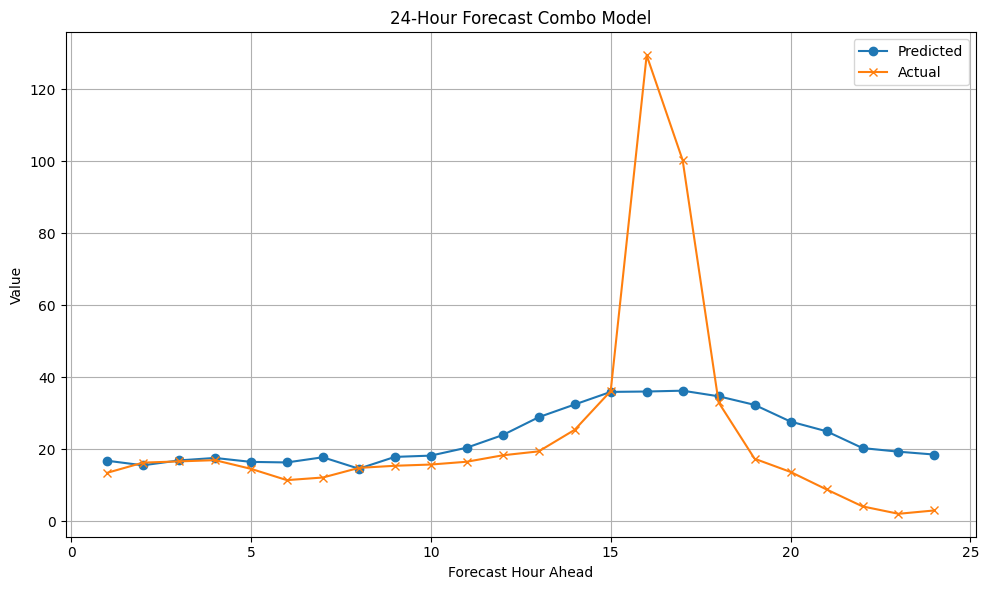

In [49]:
import matplotlib.pyplot as plt

# Get the first row from sl_pred and sl_actual
predicted = sl_pred.iloc[2500].values
actual = sl_actual.iloc[2500].values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), predicted, label='Predicted', marker='o')
plt.plot(range(1, 25), actual, label='Actual', marker='x')
plt.title("24-Hour Forecast Combo Model")
plt.xlabel("Forecast Hour Ahead")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------------------
# 0.  Small helpers
# ----------------------------------------------------------------
def to_numpy(t):
    """Detach, move to CPU, NumPy."""
    return t.detach().cpu().numpy()

# --- everywhere you invert -------------------------------------
def inverse_transform(log_scaled):
    rescaled = log_scaled * y_std_reg.values + y_mean_reg.values
    return np.exp(rescaled) - 1 + offsets["DAP"]        # <- use the right shift

def make_residuals(x_seq, y_seq):
    """Return actual prices, baseline preds, and residuals (all original scale)."""
    with torch.no_grad():
        preds = model(torch.tensor(x_seq, dtype=torch.float32, device=device))
    preds_orig = inverse_transform(to_numpy(preds))
    y_orig     = inverse_transform(y_seq)
    return y_orig, preds_orig, y_orig - preds_orig

In [24]:
y_tv_orig,  base_tv_pred,  res_tv  = make_residuals(
    np.concatenate([x_train_lstm, x_val_lstm]),
    np.concatenate([y_train_lstm, y_val_lstm])
)
y_test_orig, base_test_pred, res_test = make_residuals(x_test_lstm, y_test_lstm)


In [25]:
# ----------------------------------------------------------------
# 2.  Label spikes
#     Rule: |residual| > Q3 + 1.5·IQR   (tune iqr_mult if needed)
# ----------------------------------------------------------------
iqr_mult = 1.5
q1, q3   = np.percentile(np.abs(res_tv), [25, 75])
threshold = q3 + iqr_mult * (q3 - q1)
print(f"Spike threshold = {threshold:,.2f} $/MWh")

spike_flag_tv   = (np.abs(res_tv)   > threshold).astype(int)   # (N_seq, 24)
spike_flag_test = (np.abs(res_test) > threshold).astype(int)

Spike threshold = 30.54 $/MWh


In [26]:
# ----------------------------------------------------------------
# 3.  Flatten each 24‑step sequence so every hour is one sample
#     (feature vector = most‑recent hour of the window)
# ----------------------------------------------------------------
def flatten_features(x_seq):
    """Return X of shape (N_seq*24, n_features) using last hour of each window."""
    X_last = x_seq[:, -1, :]                # (N_seq, n_features)
    return np.repeat(X_last, 24, axis=0)    # repeat for 24 hrs / seq

def flatten_labels(label_seq):
    """Flatten (N_seq, 24) ➔ (N_seq*24,)"""
    return label_seq.reshape(-1)

X_tv   = flatten_features(np.concatenate([x_train_lstm, x_val_lstm]))
X_test = flatten_features(x_test_lstm)
y_flag_tv  = flatten_labels(spike_flag_tv)
y_flag_te  = flatten_labels(spike_flag_test)
y_size_tv  = flatten_labels(res_tv)

X_flag_tr, X_flag_val, y_flag_tr, y_flag_val = train_test_split(
    X_tv, y_flag_tv, test_size=0.2, stratify=y_flag_tv, random_state=42
)

In [27]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier

# start with 10 trees, then add 10 more each loop (warm_start=True keeps the old trees)
clf = GradientBoostingClassifier(
    n_estimators=10,           # will grow to 300
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    warm_start=True            # <‑‑ key: lets us add trees incrementally
)

max_estimators   = 300         # final model size
step             = 10          # “epoch” size
best_val_acc     = 0.0

for n in range(10, max_estimators + 1, step):
    t0 = time()
    clf.fit(X_flag_tr, y_flag_tr)                 # adds (n_estimators‑prev) new trees
    val_acc = clf.score(X_flag_val, y_flag_val)
    elapsed = time() - t0
    
    print(f"Trees: {n:3d} | Val Acc: {val_acc:.3f} | Δt: {elapsed:5.1f}s")
    
    # simple early‑stopping example (optional)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_n       = n
    elif n - best_n >= 50:      # no improvement for 50 trees ≈ 5 “epochs”
        print("Early‑stopping: validation accuracy plateaued.")
        break
    
    # prepare for next epoch
    clf.n_estimators += step    # grow the ensemble by another 10 trees

Trees:  10 | Val Acc: 0.923 | Δt:   7.4s
Trees:  20 | Val Acc: 0.928 | Δt:   7.3s
Trees:  30 | Val Acc: 0.928 | Δt:   7.2s
Trees:  40 | Val Acc: 0.929 | Δt:   7.4s
Trees:  50 | Val Acc: 0.929 | Δt:   7.5s
Trees:  60 | Val Acc: 0.929 | Δt:   7.8s
Trees:  70 | Val Acc: 0.929 | Δt:   7.7s
Trees:  80 | Val Acc: 0.929 | Δt:   7.9s
Trees:  90 | Val Acc: 0.929 | Δt:   7.8s
Trees: 100 | Val Acc: 0.929 | Δt:   8.0s
Trees: 110 | Val Acc: 0.929 | Δt:   7.8s
Trees: 120 | Val Acc: 0.929 | Δt:   8.4s
Trees: 130 | Val Acc: 0.929 | Δt:   8.2s
Trees: 140 | Val Acc: 0.929 | Δt:   8.5s
Trees: 150 | Val Acc: 0.929 | Δt:   8.2s
Trees: 160 | Val Acc: 0.929 | Δt:   8.3s
Trees: 170 | Val Acc: 0.929 | Δt:   8.3s
Trees: 180 | Val Acc: 0.930 | Δt:   8.1s
Trees: 190 | Val Acc: 0.930 | Δt:   8.4s
Trees: 200 | Val Acc: 0.930 | Δt:   8.3s
Trees: 210 | Val Acc: 0.930 | Δt:   8.4s
Trees: 220 | Val Acc: 0.930 | Δt:   8.5s
Trees: 230 | Val Acc: 0.930 | Δt:   8.5s
Trees: 240 | Val Acc: 0.930 | Δt:   8.5s
Trees: 250 | Val

In [28]:
clf.fit(X_flag_tr, y_flag_tr)
print(f"Spike‑classifier validation accuracy: {clf.score(X_flag_val, y_flag_val):.3f}")

Spike‑classifier validation accuracy: 0.930


In [29]:
# ----------------------------------------------------------------
# 5.  Train spike‑size regressor  — incremental “epochs” of 10 trees
# ----------------------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import mean_absolute_error

# --- keep only rows that are spikes -----------------------------------------
spike_rows = y_flag_tv == 1
X_size = X_tv[spike_rows]
y_size = y_size_tv[spike_rows]

# --- split into train / validation ------------------------------------------
X_sz_tr, X_sz_val, y_sz_tr, y_sz_val = train_test_split(
    X_size, y_size, test_size=0.2, random_state=42
)

# --- incremental GBM ---------------------------------------------------------
reg = GradientBoostingRegressor(
    n_estimators=10,            # will grow to 400
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    warm_start=True             # <‑‑ allows incremental growth
)

max_estimators = 400
step           = 10
best_val_mae   = float("inf")

for n in range(10, max_estimators + 1, step):
    t0 = time()
    reg.fit(X_sz_tr, y_sz_tr)                     # adds new trees
    val_mae = mean_absolute_error(y_sz_val, reg.predict(X_sz_val))
    elapsed = time() - t0
    
    print(f"Trees: {n:3d} | Val MAE: {val_mae:7.3f} | Δt: {elapsed:5.1f}s")
    
    # simple early‑stopping rule (optional)
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_n       = n
    elif n - best_n >= 50:          # no improvement for 50 trees ≈ 5 “epochs”
        print("Early‑stopping: validation MAE plateaued.")
        break
    
    # prepare for next epoch
    reg.n_estimators += step


Trees:  10 | Val MAE: 302.174 | Δt:   0.8s
Trees:  20 | Val MAE: 253.988 | Δt:   0.8s
Trees:  30 | Val MAE: 226.524 | Δt:   0.8s
Trees:  40 | Val MAE: 211.077 | Δt:   0.8s
Trees:  50 | Val MAE: 202.266 | Δt:   0.8s
Trees:  60 | Val MAE: 197.657 | Δt:   0.8s
Trees:  70 | Val MAE: 194.527 | Δt:   0.8s
Trees:  80 | Val MAE: 192.678 | Δt:   0.8s
Trees:  90 | Val MAE: 191.301 | Δt:   0.8s
Trees: 100 | Val MAE: 190.369 | Δt:   0.8s
Trees: 110 | Val MAE: 189.533 | Δt:   0.8s
Trees: 120 | Val MAE: 188.361 | Δt:   0.8s
Trees: 130 | Val MAE: 188.075 | Δt:   0.8s
Trees: 140 | Val MAE: 187.513 | Δt:   0.8s
Trees: 150 | Val MAE: 187.224 | Δt:   0.8s
Trees: 160 | Val MAE: 186.786 | Δt:   0.8s
Trees: 170 | Val MAE: 186.300 | Δt:   0.8s
Trees: 180 | Val MAE: 185.717 | Δt:   0.8s
Trees: 190 | Val MAE: 185.367 | Δt:   0.8s
Trees: 200 | Val MAE: 184.931 | Δt:   0.8s
Trees: 210 | Val MAE: 184.410 | Δt:   0.8s
Trees: 220 | Val MAE: 184.169 | Δt:   0.8s
Trees: 230 | Val MAE: 183.940 | Δt:   0.8s
Trees: 240 

In [30]:
reg.fit(X_tv[spike_rows], y_size_tv[spike_rows])
print(f"Spike‑size regressor trained on {spike_rows.sum()} rows.")

Spike‑size regressor trained on 64911 rows.


In [31]:
# ----------------------------------------------------------------
# 6.  Combine on the test set
# ----------------------------------------------------------------
# -- predict spike probability and hard 0/1 flag
flag_prob = clf.predict_proba(X_test)[:, 1]
flag_pred = (flag_prob > 0.5).astype(int)

# -- predict spike size (signed); ignore where no spike predicted
size_pred = reg.predict(X_test)
size_pred[flag_pred == 0] = 0.0

# -- reshape back to (N_seq, 24)
flag_pred = flag_pred.reshape(base_test_pred.shape)
size_pred = size_pred.reshape(base_test_pred.shape)

final_pred = base_test_pred + size_pred  # baseline + spike correction

In [32]:
# ----------------------------------------------------------------
# 7.  Evaluation
# ----------------------------------------------------------------


print("\nPerformance on 2023 test set (original $/MWh scale)")
print("\nBaseline LSTM")
evaluate_prediction(base_test_pred,  y_test_orig)
print("\nWith Spikes")
evaluate_prediction(final_pred,      y_test_orig)


Performance on 2023 test set (original $/MWh scale)

Baseline LSTM
MAE: 35.54
RMSE: 203.73

With Spikes
MAE: 36.33
RMSE: 202.34


(np.float64(36.32693670529957), np.float64(202.3360643069578))

In [33]:
index_test = df.loc['2023-01-01 23:00:00':'2023-12-30 23:00:00'].index

sl_actual       = pd.DataFrame(y_test_orig,      index=index_test)
sl_pred         = pd.DataFrame(base_test_pred,   index=index_test)
sl_pred_spike   = pd.DataFrame(final_pred,       index=index_test)   # <‑‑ NEW

print("Shapes  |  actual:", sl_actual.shape,
      "|  baseline:", sl_pred.shape,
      "|  with‑spikes:", sl_pred_spike.shape)

Shapes  |  actual: (8713, 24) |  baseline: (8713, 24) |  with‑spikes: (8713, 24)


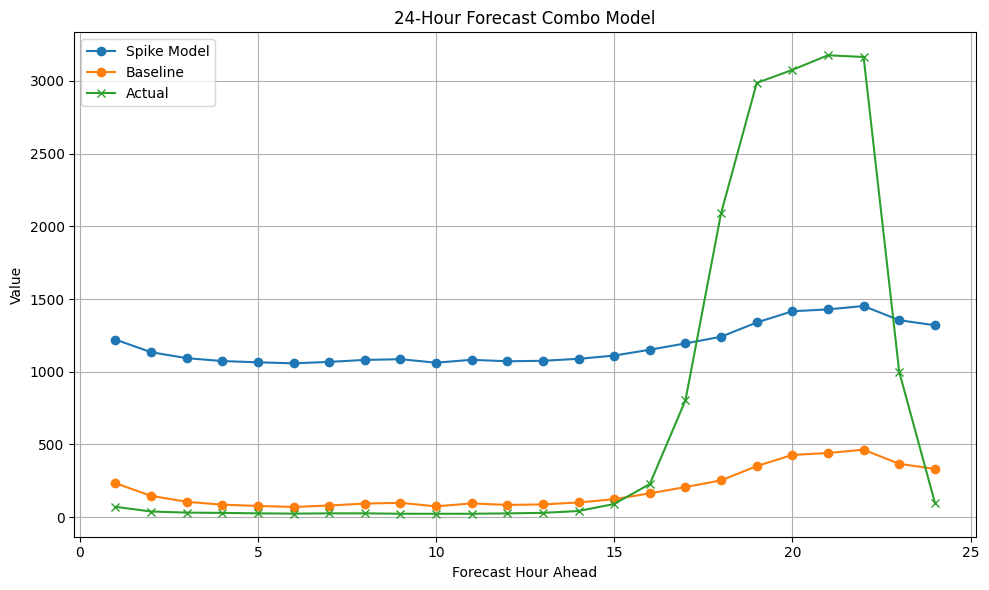

In [47]:
# Get the first row from sl_pred and sl_actual
spike = sl_pred_spike.iloc[5662].values
predicted = sl_pred.iloc[5662].values
actual = sl_actual.iloc[5662].values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), spike, label='Spike Model', marker='o')
plt.plot(range(1, 25), predicted, label='Baseline', marker='o')
plt.plot(range(1, 25), actual, label='Actual', marker='x')
plt.title("24-Hour Forecast Combo Model")
plt.xlabel("Forecast Hour Ahead")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
print("spikes predicted:", np.count_nonzero(flag_pred))

spikes predicted: 936


In [36]:
np.abs(size_pred).max()

np.float64(1262.0220405374353)

In [43]:
import numpy as np
import pandas as pd

# --- make sure the three DataFrames exist -----------------------
for name in ("sl_actual", "sl_pred", "sl_pred_spike"):
    if name not in globals():
        raise RuntimeError(f"Missing DataFrame: {name}. "
                           "Run the baseline and spike‑pipeline cells first.")

# --- 1. absolute correction matrix ------------------------------
abs_corr = (sl_pred_spike - sl_pred).abs()

# --- 2. flatten and take the 20 largest -------------------------
flat_corr = abs_corr.stack()                      # MultiIndex (timestamp, lead_hour)
top20 = flat_corr.nlargest(50)

# --- 3. build a tidy table with the row index added --------------
records = []
for rank, ((ts_label, lead_hour), delta) in enumerate(top20.items(), start=1):
    row_pos      = sl_actual.index.get_loc(ts_label)         # integer position
    start_time   = ts_label                                  # forecast issued
    target_time  = start_time + pd.Timedelta(hours=lead_hour)

    baseline_val = sl_pred.iat[row_pos,   lead_hour]
    spike_val    = sl_pred_spike.iat[row_pos, lead_hour]
    actual_val   = sl_actual.iat[row_pos, lead_hour]

    records.append({
        "Row Index":           row_pos,                     # new column with index position
        "Rank":                rank,
        "Issued":              start_time,
        "Lead‑Hour":           lead_hour + 1,               # 1‑based
        "Target Time":         target_time,
        "Baseline ($/MWh)":    baseline_val,
        "Spike Model ($/MWh)": spike_val,
        "Actual ($/MWh)":      actual_val,
        "Abs Correction":      delta
    })

df_top20 = pd.DataFrame(records)

# --- 4. pretty‑print --------------------------------------------
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", "{:,.2f}".format)
print(df_top20.to_string(index=False))


 Row Index  Rank              Issued  Lead‑Hour         Target Time  Baseline ($/MWh)  Spike Model ($/MWh)  Actual ($/MWh)  Abs Correction
      5656     1 2023-08-25 15:00:00          1 2023-08-25 15:00:00            370.56             1,632.58        3,692.02        1,262.02
      5656     2 2023-08-25 15:00:00          2 2023-08-25 16:00:00            415.30             1,677.32        4,020.85        1,262.02
      5656     3 2023-08-25 15:00:00          3 2023-08-25 17:00:00            418.42             1,680.44        4,034.02        1,262.02
      5656     4 2023-08-25 15:00:00          4 2023-08-25 18:00:00            339.36             1,601.38        4,200.00        1,262.02
      5656     5 2023-08-25 15:00:00          5 2023-08-25 19:00:00            289.21             1,551.24        3,639.53        1,262.02
      5656     6 2023-08-25 15:00:00          6 2023-08-25 20:00:00            221.95             1,483.98          558.59        1,262.02
      5656     7 2023-08-25

In [38]:
print("Number of spikes in test set:", spike_flag_test.sum())


Number of spikes in test set: 22677
